<a href="https://colab.research.google.com/github/leem928/AI_Project/blob/main/easyOCR%EA%B8%B0%EB%B2%95%EB%B3%84%EB%A1%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install easyocr jiwer matplotlib seaborn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 kB 34.3 MB/s eta 0:00:00


In [2]:
import easyocr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jiwer import wer, cer
import os

print("✅ EasyOCR 버전:", easyocr.__version__)
print("✅ NumPy 버전:", np.__version__)

✅ EasyOCR 버전: 1.7.2
✅ NumPy 버전: 2.0.2


In [3]:
import zipfile, os

# 업로드한 zip 파일 경로 (json.zip / images_no.zip 등)
json_zip = "/content/json.zip"
img_zip = "/content/images_no.zip"

# 폴더 생성
os.makedirs("/content/json", exist_ok=True)
os.makedirs("/content/images_no", exist_ok=True)

# 압축 해제
with zipfile.ZipFile(json_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/json")

with zipfile.ZipFile(img_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/images_no")

print("✅ 압축 해제 완료")

✅ 압축 해제 완료


In [10]:
import json
import cv2
import numpy as np
import os
from glob import glob
from tqdm import tqdm

# 경로 설정
json_dir = "/content/json/json"                 # JSON 폴더
image_dir = "/content/images_no/images_no"      # 원본 이미지 폴더
output_dir = "/content/cropped_images"          # 잘라낸 결과 폴더
os.makedirs(output_dir, exist_ok=True)

valid_exts = [".jpg", ".jpeg", ".png"]
image_map = {os.path.splitext(os.path.basename(p))[0]: p
             for ext in valid_exts
             for p in glob(os.path.join(image_dir, f"*{ext}"))}

print(f"🔍 총 JSON 파일: {len(os.listdir(json_dir))}")
print(f"📁 출력 폴더: {output_dir}")

for file in tqdm(os.listdir(json_dir)):
    if not file.endswith(".json"):
        continue

    json_path = os.path.join(json_dir, file)
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    img_name = data.get("name") or file.replace(".json", ".jpg")
    base_name = os.path.splitext(img_name)[0]

    # 실제 이미지 경로 찾기
    img_path = None
    for ext in valid_exts:
        candidate = f"{base_name}{ext}"
        if candidate in [os.path.basename(v) for v in image_map.values()]:
            img_path = image_map[base_name]
            break

    if not img_path or not os.path.exists(img_path):
        print(f"⚠️ {img_name} 이미지 없음, 건너뜀")
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    # type=2 polygon 영역들 추출
    polygons = []
    for ann in data.get("annotations", []):
        for poly in ann.get("polygons", []):
            if str(poly.get("type")) == "2" and "points" in poly:
                pts = np.array(poly["points"], np.int32)
                polygons.append(pts)

    if not polygons:
        print(f"⚠️ type=2 없음: {img_name}")
        continue

    # 모든 type=2 영역의 bounding box 구하기
    x_min = min(pt[:,0].min() for pt in polygons)
    y_min = min(pt[:,1].min() for pt in polygons)
    x_max = max(pt[:,0].max() for pt in polygons)
    y_max = max(pt[:,1].max() for pt in polygons)

    # 안전하게 범위 조정
    h, w = img.shape[:2]
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(w, x_max)
    y_max = min(h, y_max)

    # ✅ type=2 영역만 crop
    cropped = img[y_min:y_max, x_min:x_max]

    save_path = os.path.join(output_dir, os.path.basename(img_path))
    cv2.imwrite(save_path, cropped)

print("\n✅ 전성분(type=2) 영역만 crop 완료!")
print(f"📁 저장 경로: {output_dir}")

🔍 총 JSON 파일: 100
📁 출력 폴더: /content/cropped_images


100%|██████████| 100/100 [00:08<00:00, 12.05it/s]


✅ 전성분(type=2) 영역만 crop 완료!
📁 저장 경로: /content/cropped_images


In [11]:
import pandas as pd

csv_path = "/content/ground_truth.csv"
rows = []

for file in os.listdir(json_dir):
    if not file.endswith(".json"):
        continue
    json_path = os.path.join(json_dir, file)
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    filename = data.get("name") or file.replace(".json", ".jpg")
    gt_texts = []

    for ann in data.get("annotations", []):
        for poly in ann.get("polygons", []):
            if str(poly.get("type")) == "2":
                text = poly.get("text", "").strip()
                if text:
                    gt_texts.append(text)

    if gt_texts:
        rows.append({"filename": filename, "gt_text": " ".join(gt_texts)})

df = pd.DataFrame(rows)
df.to_csv(csv_path, index=False, encoding='utf-8-sig')

print(f"✅ ground_truth.csv 생성 완료 ({len(df)}개 이미지)")
df.head()

✅ ground_truth.csv 생성 완료 (100개 이미지)


,filename,gt_text
0,cosmetics_00462.jpg,"소듐팔메이트, (CI77891), 전성분 소듐팔메이트, (두보레 (CI77891), 글리세린, 메틸프로피오날, 국화추출물, 1.1%), 소듐클로라이드, 정제수, 팜커넬애씨드, 향료 티타늄디옥사이드 폴리쿼터늄-6, 에티드로닉애씨드, 핵실신남알, 시트로넬올, 에틸핵실글리세린 부틸페닐 테트라소듐이디티에이, 테트라 에탄올, 부틸렌글라이콜, 전성분 (두보레 글리세린, 올리브오일, 페녹시에탄올, 소듐팜커넬레이트, 정제수, 팜커넬애씨드, 향료 1.1%), 다이소듐코코암포다이아세테이트, 소듐클로라이드, 티타늄디옥사이드 폴리쿼터늄-6, 리날룰, 헥실신남알, 시트로넬올, 에티드로닉애씨드, 부틸페닐 테트라소듐이디티에이, 에탄올, 테트라 부틸렌글라이콜, 에틸헥실글리세린 전성분 (두보레 글리세린, 소듐팜커넬레이트, 1.1%), 다이소듐코코암포다이아세테이트, 올리브오일, 헥실신남알, 리날룰, 정제수, 팜커넬애씨드, 향료 소듐클로라이드, 티타늄디옥사이드 폴리쿼터늄-6, 에티드로닉애씨드, 부틸페닐 테트라소듐이디티에이, 테트라 페녹시에탄올, 시트로넬올, 에틸헥실글리세린 에탄올, 부틸렌글라이콜, 전성분 (두보레 (CI77891), 글리세린, 소듐팜커넬레이트, 정제수, 팜커넬애씨드, 향료 1.1%), 소듐클로라이드, 티타늄디옥사이드 폴리쿼터늄-6, 헥실신남알, 시트로넬올, 페녹시에탄올, 에티드로닉애씨드, 부틸페닐 테트라소듐이디티에이, 에탄올, 에틸헥실글리세린 부틸렌글라이콜, 테트라"
1,cosmetics_00367.jpg,"전성분 정제수, 변성알코올, 글리세린, 미리스틱 애씨드, 다이소듐이디티에이, 프로판다이올, 알로에베라잎 추출물, 코코-글루코사이드, 알지닌, 알라토인, 녹차추출물, 시트릭애씨드, 연꽃추출물, 라우릭애씨드, 다이 프로필렌글라이콜, 멘톨, 포타슘하이드록사이드, 티트리잎오일, 편백수, 부틸렌글라이콜, 1,2-헥산다이올, 향료, 녹차카테킨, 커먼자스민꽃추출물, 매실추출물, 락틱애씨드 라우릴하이드록시설테인, 스테아릭애씨드, 팔미틱애씨드, 구기자추출물, 아라키딕애씨드, 에틸헥실글리세린,"
2,cosmetics_00354.jpg,"| 전성분 | 코-베타인, 정제수, 포타슘코코일글루타메이트, 라우릴글루코사이드, 흰버드나무껍질추출물, 다이소듐코코암포다이아세테이트, 코코-글루코사이드, 회화나무뿌리추출물, 코 소듐클로라이드, 복사나무잎추출물, 글리세릴올리에이트, 아크릴레잍,/ 소듐코코일이세티오 에틸헥 메틸프로판다이올, 퀼라자껍질추출물, 소듐코코일글루타메이트, 시트릭애씨드, 부틸렌글라이콜, 향료 귀리커넬오일, 헥실렌글라이콜, 1,2-헥산다이올, 뽕나무잎추출물, 매실추출물, 팥추출물, 카프릴릴글라이콜, C10-30알킬아크릴레이트크로스폴리머, 네이트, 알지닌, 실글리세린, 다이소듐이디티에이,"
3,cosmetics_00088.jpg,"전성분 정제수, 변성알코올, 글리세린, 라우릭애씨드, 다이 프로필렌글라이콜, 라우릴하이드록시설테인, 미리스틱 애씨드, 코코-글루코사이드, 멘톨, 포타슘하이드록사이드, 스테아릭애씨드, 팔미틱애씨드, 다이소듐이디티에이, 알지닌, 알란토인, 티트리잎오일, 편백수, 부틸렌글라이콜, 구기자 추출물, 아라키딕애씨드, 프로판다이올, 알로에베라잎 추출물, 1,2-헥산다이올, 향료, 녹차카테킨, 커먼자스민 꽃추출물, 에틸헥실글리세린, 녹차추출물, 시트릭애씨드, 연꽃추출물, 매실추출물, 락틱애씨드,"
4,cosmetics_00282.jpg,"【전성분】 오일, 에틸헥실팔미테이트, 스위트아몬드오일, 올리브오일, 토코페릴아세테이트, 마카다미아씨오일, 호호바씨오일, 에틸헥실글리세린, 향료 코코넛야자"


In [12]:
import easyocr
from jiwer import wer, cer
import numpy as np
import pandas as pd
import os

reader = easyocr.Reader(['ko', 'en'])

image_dir = "/content/cropped_images"
gt_path = "/content/ground_truth.csv"

gt_df = pd.read_csv(gt_path)
results = []

print(f"📸 OCR 시작 ({len(gt_df)}개 이미지)")

for _, row in gt_df.iterrows():
    fname = row['filename']
    gt_text = str(row['gt_text']).strip()
    base = os.path.splitext(fname)[0]

    img_path = None
    for ext in [".png", ".jpg", ".jpeg"]:
        path = os.path.join(image_dir, f"{base}{ext}")
        if os.path.exists(path):
            img_path = path
            break

    if not img_path:
        continue

    try:
        pred = reader.readtext(img_path, detail=0)
        pred_text = " ".join(pred).strip()

        cer_val = cer(gt_text, pred_text)
        wer_val = wer(gt_text, pred_text)

        gt_chars, pred_chars = list(gt_text), list(pred_text)
        TP = len(set(gt_chars) & set(pred_chars))
        FP = len(set(pred_chars) - set(gt_chars))
        FN = len(set(gt_chars) - set(pred_chars))
        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)

        results.append({
            "filename": fname,
            "gt": gt_text,
            "pred": pred_text,
            "CER": cer_val,
            "WER": wer_val,
            "Precision": precision,
            "Recall": recall
        })
    except Exception as e:
        print(f"⚠️ {fname} 오류: {e}")

ocr_df = pd.DataFrame(results)
ocr_df.to_csv("/content/easyocr_eval_results.csv", index=False, encoding='utf-8-sig')
print("✅ easyocr_eval_results.csv 저장 완료!")

📸 OCR 시작 (100개 이미지)
✅ easyocr_eval_results.csv 저장 완료!


===== 📄 OCR 이미지별 성능 결과 =====


,filename,CER,WER,Precision,Recall
0,cosmetics_00462.jpg,0.834746,1.000000,0.294118,0.561798
1,cosmetics_00367.jpg,0.813433,1.000000,0.484848,0.516129
2,cosmetics_00354.jpg,0.766026,0.944444,0.745283,0.806122
3,cosmetics_00088.jpg,0.638376,0.973684,0.435644,0.468085
4,cosmetics_00282.jpg,0.752941,1.000000,0.659574,0.704545
5,cosmetics_00199.jpg,0.809756,1.000000,0.712121,0.752000
6,cosmetics_00438.jpg,0.804878,1.000000,0.495652,0.508929
7,cosmetics_00406.jpg,0.235808,0.866667,0.755102,0.831461
8,cosmetics_00205.jpg,0.833179,1.042857,0.446154,0.861386
9,cosmetics_00283.jpg,0.948052,2.600000,0.447552,0.727273



===== 📊 평균 성능 =====
평균 CER: 0.8131
평균 WER: 1.1651
평균 Precision: 0.6076
평균 Recall: 0.6946


/tmp/ipython-input-4050238091.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=mean_values, palette="coolwarm")
/tmp/ipython-input-4050238091.py:46: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4050238091.py:46: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4050238091.py:46: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4050238091.py:46: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4050238091.py:46: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/

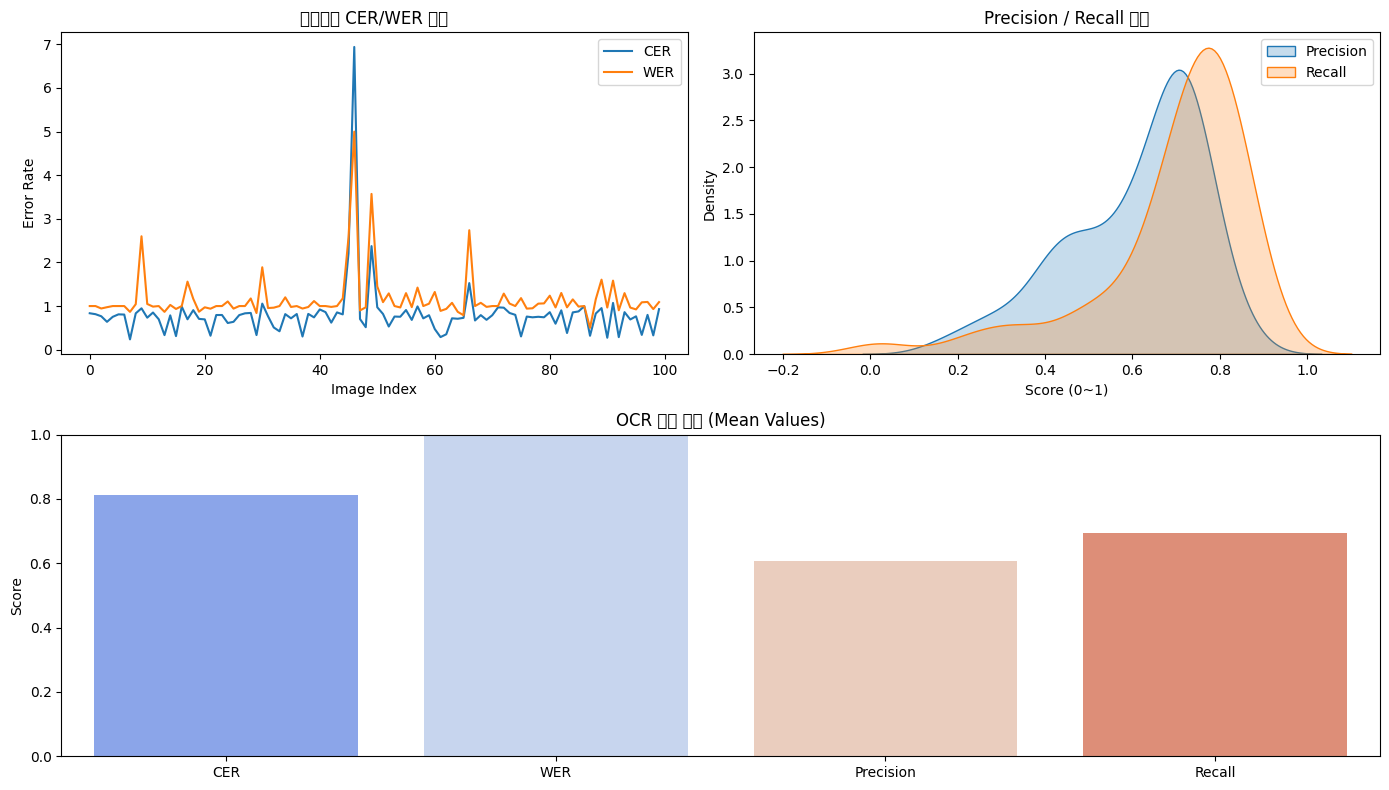

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

print("===== 📄 OCR 이미지별 성능 결과 =====")
display(ocr_df[['filename', 'CER', 'WER', 'Precision', 'Recall']])

# 평균 출력
print("\n===== 📊 평균 성능 =====")
print(f"평균 CER: {ocr_df['CER'].mean():.4f}")
print(f"평균 WER: {ocr_df['WER'].mean():.4f}")
print(f"평균 Precision: {ocr_df['Precision'].mean():.4f}")
print(f"평균 Recall: {ocr_df['Recall'].mean():.4f}")

# 시각화
plt.figure(figsize=(14, 8))

# (1) 이미지별 CER/WER
plt.subplot(2, 2, 1)
sns.lineplot(x=ocr_df.index, y=ocr_df['CER'], label='CER')
sns.lineplot(x=ocr_df.index, y=ocr_df['WER'], label='WER')
plt.title("이미지별 CER/WER 변화")
plt.xlabel("Image Index")
plt.ylabel("Error Rate")
plt.legend()

# (2) Precision/Recall 분포
plt.subplot(2, 2, 2)
sns.kdeplot(ocr_df['Precision'], fill=True, label='Precision')
sns.kdeplot(ocr_df['Recall'], fill=True, label='Recall')
plt.title("Precision / Recall 분포")
plt.xlabel("Score (0~1)")
plt.legend()

# (3) 평균 막대그래프
plt.subplot(2, 1, 2)
metrics = ['CER', 'WER', 'Precision', 'Recall']
mean_values = [ocr_df[m].mean() for m in metrics]
sns.barplot(x=metrics, y=mean_values, palette="coolwarm")
plt.title("OCR 평균 성능 (Mean Values)")
plt.ylim(0, 1)
plt.ylabel("Score")

plt.tight_layout()
plt.show()

In [15]:
print("===== 🧐 OCR 인식 결과 샘플 (상위 10개) =====")

for i, row in ocr_df.head(20).iterrows():
    print(f"📄 파일명: {row['filename']}")
    print(f"✅ 정답(GT): {row['gt'][:200]}")      # 너무 길면 200자까지만
    print(f"🤖 예측(PRED): {row['pred'][:200]}")
    print(f"📉 CER={row['CER']:.3f}, WER={row['WER']:.3f}, "
          f"Precision={row['Precision']:.3f}, Recall={row['Recall']:.3f}")
    print("-"*100)

===== 🧐 OCR 인식 결과 샘플 (상위 10개) =====
📄 파일명: cosmetics_00462.jpg
✅ 정답(GT): 소듐팔메이트, (CI77891), 전성분 소듐팔메이트, (두보레 (CI77891), 글리세린, 메틸프로피오날, 국화추출물, 1.1%), 소듐클로라이드, 정제수, 팜커넬애씨드, 향료 티타늄디옥사이드 폴리쿼터늄-6, 에티드로닉애씨드, 핵실신남알, 시트로넬올, 에틸핵실글리세린 부틸페닐 테트라소듐이디티에이, 테트라 에탄올, 부틸렌글라이콜, 전성분 (두보레 글리세린
🤖 예측(PRED): 전m문 소콤플이트 빌리 뜨 정집탤 P거텔애득 문리물원_ ~이 티터u다록사이드 (@E8S= 테이트 옮리터늄 글라체린 별M 에럿,로 얘씨므 조페 예텔로마 신담일 데플되소 문이되타에이 테트리튼 또문에터 지트론필올 에린몰 룻출렌글리이 중최충록록론 (독실에터올 프출렉질물리체런 중량 (@Qg 분포임) $8입현조새 문답 톤필-텔레이 저체= 수플픽씨대_흥로 (흉훨 리서 
📉 CER=0.835, WER=1.000, Precision=0.294, Recall=0.562
----------------------------------------------------------------------------------------------------
📄 파일명: cosmetics_00367.jpg
✅ 정답(GT): 전성분 정제수, 변성알코올, 글리세린, 미리스틱 애씨드, 다이소듐이디티에이, 프로판다이올, 알로에베라잎 추출물, 코코-글루코사이드, 알지닌, 알라토인, 녹차추출물, 시트릭애씨드, 연꽃추출물, 라우릭애씨드, 다이 프로필렌글라이콜, 멘톨, 포타슘하이드록사이드, 티트리잎오일, 편백수, 부틸렌글라이콜, 1,2-헥산다이올, 향료, 녹차카테킨, 커먼자스민꽃추출물, 매
🤖 예측(PRED): 전성문 증제수 변성일국올 글리관 리스이"트 더아섬로플런물리이블 리우립히어드록시설데인_ 미리스틱이씨트 코코-극류코시이트 민물 창려습하이트록시이트 스테이j이찌트 팔미릭이째트 티이복이이 터터에이 일치